# Semeval 2025 Task 10
### Subtask 2: Narrative Classification

Given a news article and a [two-level taxonomy of narrative labels](https://propaganda.math.unipd.it/semeval2025task10/NARRATIVE-TAXONOMIES.pdf) (where each narrative is subdivided into subnarratives) from a particular domain, assign to the article all the appropriate subnarrative labels. This is a multi-label multi-class document classification task.

## Multi-head per narrative model

### 1.1 Loading pre-saved variables

We start by loading our pre-saved variables:

In [1]:
import pickle
import os
import pandas as pd

root_dir = "../../"
base_save_folder_dir = '../saved/'
dataset_folder = os.path.join(base_save_folder_dir, 'Dataset')

with open(os.path.join(dataset_folder, 'dataset_train_cleaned.pkl'), 'rb') as f:
    dataset_train = pickle.load(f)

In [2]:
dataset_train.head()

,language,article_id,content,narratives,subnarratives,narratives_encoded,subnarratives_encoded,aggregated_subnarratives
0,RU,RU-URW-1161.txt,<PARA>в ближайшие два месяца сша будут стремит...,[URW: Blaming the war on others rather than th...,"[The West are the aggressors, Other, The West ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 1, 0, 0, 0], [1, 0, 0], [1, 0, 0, 0], [1,..."
1,RU,RU-URW-1175.txt,<PARA>в ес испугались последствий популярности...,"[URW: Discrediting the West, Diplomacy, URW: D...","[The West is weak, Other, The EU is divided]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 1, 0, 0, 0], [1, 0, 0], [1, 0, 0, 0], [1,..."
2,RU,RU-URW-1149.txt,<PARA>возможность признания аллы пугачевой ино...,[URW: Distrust towards Media],[Western media is an instrument of propaganda],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0], [0,..."
3,RU,RU-URW-1015.txt,<PARA>азаров рассказал о смене риторики киева ...,"[URW: Discrediting Ukraine, URW: Discrediting ...","[Ukraine is a puppet of the West, Discrediting...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0], [0,..."
4,RU,RU-URW-1001.txt,<PARA>в россиянах проснулась массовая любовь к...,[URW: Praise of Russia],[Russia is a guarantor of peace and prosperity],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0], [0,..."


In [3]:
misc_folder = os.path.join(base_save_folder_dir, 'Misc')

with open(os.path.join(misc_folder, 'narrative_to_subnarratives.pkl'), 'rb') as f:
    narrative_to_subnarratives = pickle.load(f)

In [4]:
with open(os.path.join(misc_folder, 'narrative_to_subnarratives_map.pkl'), 'rb') as f:
    narrative_to_sub_map = pickle.load(f)

In [5]:
with open(os.path.join(misc_folder, 'coarse_classes.pkl'), 'rb') as f:
    coarse_classes = pickle.load(f)

with open(os.path.join(misc_folder, 'fine_classes.pkl'), 'rb') as f:
    fine_classes = pickle.load(f)

with open(os.path.join(misc_folder, 'narrative_order.pkl'), 'rb') as f:
    narrative_order = pickle.load(f)

In [6]:
dataset_train.shape

(1781, 8)

We'll also need the actual hierarchy of narratives to subnarratives for our new model.  

* Each narrative is also mapped to `Other`—this happens because if no subnarrative matches, we assign it to `Other`.

In [7]:
narrative_to_subnarratives

{'URW: Discrediting Ukraine': ['Discrediting Ukrainian government and officials and policies',
  'Discrediting Ukrainian nation and society',
  'Other',
  'Ukraine is associated with nazism',
  'Ukraine is a puppet of the West',
  'Rewriting Ukraine’s history',
  'Situation in Ukraine is hopeless',
  'Discrediting Ukrainian military',
  'Ukraine is a hub for criminal activities'],
 'URW: Discrediting the West, Diplomacy': ['Diplomacy does/will not work',
  'The EU is divided',
  'West is tired of Ukraine',
  'Other',
  'The West does not care about Ukraine, only about its interests',
  'The West is overreacting',
  'The West is weak'],
 'URW: Praise of Russia': ['Praise of Russian President Vladimir Putin',
  'Russia has international support from a number of countries and people',
  'Russia is a guarantor of peace and prosperity',
  'Other',
  'Russian invasion has strong national support',
  'Praise of Russian military might'],
 'URW: Russia is the Victim': ['Other',
  'The West is r

In [8]:
label_encoder_folder = os.path.join(base_save_folder_dir, 'LabelEncoders')

with open(os.path.join(label_encoder_folder, 'mlb_narratives.pkl'), 'rb') as f:
    mlb_narratives = pickle.load(f)

with open(os.path.join(label_encoder_folder, 'mlb_subnarratives.pkl'), 'rb') as f:
    mlb_subnarratives = pickle.load(f)

Finally, we get our embeddings:

In [9]:
import numpy as np

embeddings_folder = os.path.join(base_save_folder_dir, 'Embeddings/embeddings_train_qwen.npy')

def load_embeddings(filename):
    return np.load(filename)

train_embeddings = load_embeddings(embeddings_folder)

In [10]:
train_embeddings.shape

(1781, 1536)

In [11]:
dataset_train.head()

,language,article_id,content,narratives,subnarratives,narratives_encoded,subnarratives_encoded,aggregated_subnarratives
0,RU,RU-URW-1161.txt,<PARA>в ближайшие два месяца сша будут стремит...,[URW: Blaming the war on others rather than th...,"[The West are the aggressors, Other, The West ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 1, 0, 0, 0], [1, 0, 0], [1, 0, 0, 0], [1,..."
1,RU,RU-URW-1175.txt,<PARA>в ес испугались последствий популярности...,"[URW: Discrediting the West, Diplomacy, URW: D...","[The West is weak, Other, The EU is divided]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 1, 0, 0, 0], [1, 0, 0], [1, 0, 0, 0], [1,..."
2,RU,RU-URW-1149.txt,<PARA>возможность признания аллы пугачевой ино...,[URW: Distrust towards Media],[Western media is an instrument of propaganda],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0], [0,..."
3,RU,RU-URW-1015.txt,<PARA>азаров рассказал о смене риторики киева ...,"[URW: Discrediting Ukraine, URW: Discrediting ...","[Ukraine is a puppet of the West, Discrediting...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0], [0,..."
4,RU,RU-URW-1001.txt,<PARA>в россиянах проснулась массовая любовь к...,[URW: Praise of Russia],[Russia is a guarantor of peace and prosperity],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0], [0,..."


In [12]:
train_embeddings.shape

(1781, 1536)

In [13]:
dataset_train.shape

(1781, 8)

In [14]:
with open(os.path.join(dataset_folder, 'dataset_val_cleaned.pkl'), 'rb') as f:
    dataset_val = pickle.load(f)

In [15]:
dataset_val.shape

(178, 8)

In [16]:
dataset_val.head()

,language,article_id,content,narratives,subnarratives,narratives_encoded,subnarratives_encoded,aggregated_subnarratives
0,RU,RU-URW-1014.txt,<PARA>алаудинов: российские силы растянули и р...,[URW: Praise of Russia],[Praise of Russian military might],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0], [0,..."
1,RU,RU-URW-1174.txt,<PARA>других сценариев нет. никаких переговоро...,"[URW: Speculating war outcomes, URW: Discredit...","[Ukrainian army is collapsing, Discrediting Uk...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 1, 0, 0, 0], [1, 0, 0], [1, 0, 0, 0], [1,..."
2,RU,RU-URW-1166.txt,<PARA>попытка запада изолировать путина провал...,"[URW: Praise of Russia, URW: Distrust towards ...","[Praise of Russian President Vladimir Putin, W...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0], [0,..."
3,RU,RU-URW-1170.txt,<PARA>часть территории украины войдет в состав...,"[URW: Discrediting Ukraine, URW: Speculating w...",[Discrediting Ukrainian government and officia...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 1, 0, 0, 0], [1, 0, 0], [1, 0, 0, 0], [1,..."
4,RU,RU-URW-1004.txt,<PARA>зеленскому не очень понравилась идея о в...,"[URW: Discrediting Ukraine, URW: Discrediting ...",[Discrediting Ukrainian government and officia...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0], [0,..."


In [17]:
embeddings_folder = os.path.join(base_save_folder_dir, 'Embeddings/embeddings_dev_qwen.npy')

val_embeddings = load_embeddings(embeddings_folder)

In [18]:
val_embeddings.shape

(178, 1536)

We will use this function to filter out specific rows based on a condition for both dataset and embeddings

In [19]:
def filter_dataset_and_embeddings(dataset, embeddings, condition_fn):
    filtered_indices = dataset.index[dataset.apply(condition_fn, axis=1)].tolist()
    
    filtered_dataset = dataset.loc[filtered_indices]
    filtered_embeddings = embeddings[filtered_indices]

    return filtered_dataset, filtered_embeddings

More specifically here we only take the English validation data, since that is our focus.

In [20]:
dataset_val, val_embeddings = filter_dataset_and_embeddings(
        dataset_val, val_embeddings, lambda row: row["language"] == "EN"
)

In [21]:
dataset_val.shape

(41, 8)

In [22]:
val_embeddings.shape

(41, 1536)

In [23]:
random_state = 72

In [24]:
import torch
import numpy as np
import random

if random_state:
    print('[WARNING] Setting random state')
    torch.manual_seed(random_state)
    np.random.seed(random_state) 
    random.seed(random_state)

[WARNING] Setting random state


In [25]:
def custom_shuffling(data, embeddings):
    shuffled_indices = np.arange(len(data))
    np.random.shuffle(shuffled_indices)
    
    data = data.iloc[shuffled_indices].reset_index(drop=True)
    embeddings = embeddings[shuffled_indices]

    return data, embeddings

In [26]:
dataset_train, train_embeddings = custom_shuffling(dataset_train, train_embeddings)

In [27]:
dataset_val, val_embeddings = custom_shuffling(dataset_val, val_embeddings)

In [28]:
misc_folder = os.path.join(base_save_folder_dir, 'Misc')

In [29]:
y_train_sub_heads = dataset_train['aggregated_subnarratives'].to_numpy()
y_val_sub_heads = dataset_val['aggregated_subnarratives'].to_numpy()

In [30]:
prefer_cpu=True

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available() and not prefer_cpu
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [31]:
import torch

train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
val_embeddings_tensor = torch.tensor(val_embeddings, dtype=torch.float32).to(device)

In [32]:
input_size = train_embeddings_tensor.shape[1]
print(input_size)

1536


In [33]:
dataset_train['language'].unique()

array(['PT', 'HI', 'BG', 'EN', 'RU'], dtype=object)

Base Classifier class to visualize our models using onnx:

In [34]:
import torch.nn as nn

class BaseClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.input_shape = (1, input_size)
        self.model_name = "base_model"
        self._visualize=False
        
    def visualize(self, filepath=None, dummy_input=None):
        if not self._visualize:
            print('Skipping visualization')
            return
        if filepath is None:
            filepath = f'./visualizations/{self.model_name}.onnx'
        
        torch.onnx.export(
            self,
            dummy_input,
            filepath,
            export_params=True,
            opset_version=11,
            do_constant_folding=True,
            input_names=['input'],
            output_names=['narrative_output', 'subnarrative_outputs'],
        )
        
        print(f"Model exported to {filepath}")
        print("You can visualize this using Netron: https://netron.app/")

    def forward(self, x):
        raise NotImplementedError(
            "Forward method must be implemented by subclasses")

Now we have a model with a shared layer that captures the general features of the article.  
* The BatchNorm + ReLU combo seems to significantly improve performance by stabilizing training and speeding up convergence.
* Also, it seems like the model overfits very quickly when becoming overly complex.
  
We make predictions for the top-level narratives, followed by separate subnarrative predictions for each narrative.  

In [35]:
import torch.nn.functional as F

class MultiTaskClassifierMultiHead(BaseClassifier):
    def __init__(
        self,
        input_size,
        hidden_size=1024,
        num_narratives=len(mlb_narratives.classes_),
        narrative_to_sub_map=narrative_to_sub_map,
        dropout_rate=0.4,
        model_name="MultiTaskClassifierMultiHead" 
    ):
        super().__init__(input_size)
        self.model_name = model_name 
        
        self.shared_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size * 2),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.narrative_head = nn.Sequential(
            nn.Linear(hidden_size * 2, num_narratives),
            nn.Sigmoid()
        )

        self.subnarrative_heads = nn.ModuleDict()
        for narr_idx, sub_indices in narrative_to_sub_map.items():
            num_subs_for_this_narr = len(sub_indices)
            self.subnarrative_heads[str(narr_idx)] = nn.Sequential(
                nn.Linear(hidden_size * 2, num_subs_for_this_narr),
                nn.Sigmoid()
            )

    def forward(self, x):
        shared_out = self.shared_layer(x)
        narr_probs = self.narrative_head(shared_out)

        sub_probs_dict = {}
        for narr_idx, head in self.subnarrative_heads.items():
            sub_probs_dict[narr_idx] = head(shared_out)

        return narr_probs, sub_probs_dict


In [36]:
network_params = {
    'lr': 0.001,
    'hidden_size': 1024,
    'dropout': 0.4
}

In [37]:
model_multi_head = MultiTaskClassifierMultiHead(
    input_size=input_size,
    hidden_size=1024,
).to(device)

In [38]:
print(model_multi_head)

MultiTaskClassifierMultiHead(
  (shared_layer): Sequential(
    (0): Linear(in_features=1536, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
  (narrative_head): Sequential(
    (0): Linear(in_features=2048, out_features=22, bias=True)
    (1): Sigmoid()
  )
  (subnarrative_heads): ModuleDict(
    (13): Sequential(
      (0): Linear(in_features=2048, out_features=9, bias=True)
      (1): Sigmoid()
    )
    (14): Sequential(
      (0): Linear(in_features=2048, out_features=7, bias=True)
      (1): Sigmoid()
    )
    (19): Sequential(
      (0): Linear(in_features=2048, out_features=6, bias=True)
      (1): Sigmoid()
    )
    (20): Sequential(
      (0): Linear(in_features=2048, out_features=4, bias=True)
      (1): Sigmoid()
    )
    (15): Sequential(
      (0): Linear(in_features=2048, out_features=3, bias=True)
      (1): Sigmoid()
    )
    (11): Seq

In [39]:
!pip install onnx

In [40]:
dummy_input = torch.randn(1, model_multi_head.input_size).to(device)
model_multi_head.visualize(dummy_input=dummy_input)

Skipping visualization


In [41]:
y_train_nar = dataset_train['narratives_encoded'].tolist()
y_val_nar = dataset_val['narratives_encoded'].tolist()

y_train_sub_nar = dataset_train['subnarratives_encoded'].tolist()
y_val_sub_nar = dataset_val['subnarratives_encoded'].tolist()

We move everything to a tensor:

In [42]:
y_train_nar = torch.tensor(y_train_nar, dtype=torch.float32).to(device)
y_train_sub_nar = torch.tensor(y_train_sub_nar, dtype=torch.float32).to(device)

y_val_nar = torch.tensor(y_val_nar, dtype=torch.float32).to(device)
y_val_sub_nar = torch.tensor(y_val_sub_nar, dtype=torch.float32).to(device)

In [43]:
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
val_embeddings_tensor = torch.tensor(val_embeddings, dtype=torch.float32).to(device)

We calculate class weights to handle label imbalance in the training data. 
* This way, rare labels are given higher importance to ensure the model learns them effectively.
* The custom ```WeightedBCELoss``` applies these weights during training to balance the impact of common and rare labels, preventing the model from focusing only on frequent ones.

In [44]:

def compute_class_weights(y_train):
    total_samples = y_train.shape[0]
    class_weights = []
    for label in range(y_train.shape[1]):
        pos_count = y_train[:, label].sum().item()
        neg_count = total_samples - pos_count
        pos_weight = total_samples / (2 * pos_count) if pos_count > 0 else 0
        neg_weight = total_samples / (2 * neg_count) if neg_count > 0 else 0
        class_weights.append((pos_weight, neg_weight))
    return class_weights

class WeightedBCELoss(nn.Module):
    def __init__(self, class_weights):
        super().__init__()
        self.class_weights = class_weights

    def forward(self, probs, targets):
        bce_loss = 0
        epsilon = 1e-7
        for i, (pos_weight, neg_weight) in enumerate(self.class_weights):
            prob = probs[:, i]
            bce = -pos_weight * targets[:, i] * torch.log(prob + epsilon) - \
                  neg_weight * (1 - targets[:, i]) * torch.log(1 - prob + epsilon)
            bce_loss += bce.mean()
        return bce_loss / len(self.class_weights)

class_weights_sub_nar = compute_class_weights(y_train_sub_nar)
class_weights_nar = compute_class_weights(y_train_nar)
narrative_criterion = WeightedBCELoss(class_weights_nar)

We create a separate loss function for each hierarchy of subnarratives to handle their specific class imbalance.  

In [45]:
sub_criterion_dict = {}

for narr_idx, sub_indices in narrative_to_sub_map.items():
    local_weights = [ class_weights_sub_nar[sub_i] for sub_i in sub_indices ]

    sub_criterion = WeightedBCELoss(local_weights)
    sub_criterion_dict[str(narr_idx)] = sub_criterion

We define a loss class to handle the multi-task loss calculation.

* In the forward method, we first calculate the loss for the top-level narratives using the narrative criterion.
We then loop through each subnarrative head and compute the loss for each one similarly.


* We introduce a conditioning term that penalizes inconsistencies between narrative and subnarrative predictions. The conditioning term is there to match our hierarchical problem.

In [46]:
import logging

In [47]:
if log:
    logging.basicConfig(
        level=logging.INFO,
        format='%(message)s',
        handlers=[
            logging.FileHandler("./logs/loss_logs.log")
        ]
    )

In [48]:
class MultiHeadLoss(nn.Module):
    def __init__(self, narrative_criterion, sub_criterion_dict, 
                 condition_weight=0.3, sub_weight=0.3):
        
        super().__init__()
        self.narrative_criterion = narrative_criterion
        self.sub_criterion_dict = sub_criterion_dict
        self.condition_weight = condition_weight
        self.sub_weight = sub_weight
        logging.info("MultiHeadLoss Start")
        
    def forward(self, narr_probs, sub_probs_dict, y_narr, y_sub_heads):
        narr_loss = self.narrative_criterion(narr_probs, y_narr)
        sub_loss = 0.0
        condition_loss = 0.0
        
        for narr_idx_str, sub_probs in sub_probs_dict.items():
            narr_idx = int(narr_idx_str)
            y_sub = [row[narr_idx] for row in y_sub_heads]
            y_sub_tensor = torch.tensor(y_sub, dtype=torch.float32, device=sub_probs.device)
            
            sub_loss_func = self.sub_criterion_dict[narr_idx_str]
            sub_loss += sub_loss_func(sub_probs, y_sub_tensor)

            narr_pred = narr_probs[:, narr_idx].unsqueeze(1)
            condition_term = torch.mean(
                # Penalize high probs of sub, based on first level narr predictinos
                torch.abs(sub_probs * (1 - narr_pred)) + 
                # If a narrative is true, then the subnarrative predictions should match their actual true values.
                narr_pred * torch.abs(sub_probs - y_sub_tensor.unsqueeze(1))
            )
            condition_loss += condition_term
            
        sub_loss = sub_loss / len(sub_probs_dict)
        condition_loss = condition_loss / len(sub_probs_dict)
        
        weighted_narr_loss = (1 - self.sub_weight) * narr_loss
        weighted_sub_loss = self.sub_weight * sub_loss
        weighted_condition_loss = self.condition_weight * condition_loss
        total_loss =  (weighted_narr_loss + 
                       weighted_sub_loss + 
                       weighted_condition_loss)

        logging.info(f'{weighted_narr_loss.item()},' +
                     f'{weighted_sub_loss.item()},' +
                     f'{weighted_condition_loss.item()}')
        return total_loss

In [49]:
multi_head_loss_fn = MultiHeadLoss(narrative_criterion, sub_criterion_dict).to(device)

In [50]:
def check_weight_norms(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            norm = param.norm(2).item()
            print(f"Layer: {name} | Weight Norm: {norm:.4f}")

We define the function for training our model:

In [51]:
def train_with_multihead(
    model,
    optimizer,
    loss_fn=multi_head_loss_fn,
    train_embeddings=train_embeddings_tensor,
    y_train_nar=y_train_nar,
    y_train_sub_heads=y_train_sub_heads,
    val_embeddings=val_embeddings_tensor,
    y_val_nar=y_val_nar,
    y_val_sub_heads=y_val_sub_heads,
    patience=10,
    num_epochs=100,
    scheduler=None,
    min_delta=0.001
):
    best_val_loss = float('inf')
    best_model = None
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        train_narr_probs, train_sub_probs_dict = model(train_embeddings)
        train_loss = loss_fn(train_narr_probs, train_sub_probs_dict, y_train_nar, y_train_sub_heads)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_narr_probs, val_sub_probs_dict = model(val_embeddings)
            val_loss = loss_fn(val_narr_probs, val_sub_probs_dict, y_val_nar, y_val_sub_heads)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Training Loss: {train_loss.item():.4f}, "
              f"Validation Loss: {val_loss.item():.4f}")

        if scheduler:
            scheduler.step(val_loss)
            current_lr = scheduler.optimizer.param_groups[0]['lr']
            print(f"Current Learning Rate: {current_lr:.6f}")

        if val_loss.item() < best_val_loss - min_delta:
            best_val_loss = val_loss.item()
            patience_counter = 0
            best_model = model.state_dict().copy()
        else:
            patience_counter += 1
            print(f"Validation loss did not significantly improve for {patience_counter} epoch(s).")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    if best_model:
        model.load_state_dict(best_model)
    return model

In [52]:
optimizer_multi_head = torch.optim.AdamW(model_multi_head.parameters(),
                                         lr=network_params['lr'])

We will also initialize a scheduler to adjust the learning rate dynamically during training based on how the model is performing.

In [53]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_multi_head, 
                                                       mode='min', factor=0.5, patience=3)

Notice that the simple model doesn't have any kind of relationship between narrative and subnarrative, we will stronger the weight for subnarratives as that is where we should focus more.

In [54]:
multi_head_loss_fn_simple = MultiHeadLoss(
    narrative_criterion,
    sub_criterion_dict,
    condition_weight=0.3,
    sub_weight=0.5
    # narrative weight = 0.5
)

In [55]:
trained_multi_head_simple = train_with_multihead(
    model=model_multi_head,
    optimizer=optimizer_multi_head,
    loss_fn=multi_head_loss_fn_simple,
    patience=10,
    scheduler=scheduler
).to(device)

Epoch 1/100, Training Loss: 0.8751, Validation Loss: 1.2574
Current Learning Rate: 0.001000
Epoch 2/100, Training Loss: 0.6744, Validation Loss: 1.2510
Current Learning Rate: 0.001000
Epoch 3/100, Training Loss: 0.5871, Validation Loss: 1.2522
Current Learning Rate: 0.001000
Validation loss did not significantly improve for 1 epoch(s).
Epoch 4/100, Training Loss: 0.5196, Validation Loss: 1.2560
Current Learning Rate: 0.001000
Validation loss did not significantly improve for 2 epoch(s).
Epoch 5/100, Training Loss: 0.4799, Validation Loss: 1.2581
Current Learning Rate: 0.001000
Validation loss did not significantly improve for 3 epoch(s).
Epoch 6/100, Training Loss: 0.4529, Validation Loss: 1.2548
Current Learning Rate: 0.000500
Validation loss did not significantly improve for 4 epoch(s).
Epoch 7/100, Training Loss: 0.4288, Validation Loss: 1.2485
Current Learning Rate: 0.000500
Epoch 8/100, Training Loss: 0.4184, Validation Loss: 1.2406
Current Learning Rate: 0.000500
Epoch 9/100, Tra

The coarse, or narrative classes, to be used in the evaluation function look like this:

In [56]:
coarse_classes

['CC: Amplifying Climate Fears',
 'CC: Climate change is beneficial',
 'CC: Controversy about green technologies',
 'CC: Criticism of climate movement',
 'CC: Criticism of climate policies',
 'CC: Criticism of institutions and authorities',
 'CC: Downplaying climate change',
 'CC: Green policies are geopolitical instruments',
 'CC: Hidden plots by secret schemes of powerful groups',
 'CC: Questioning the measurements and science',
 'Other',
 'URW: Amplifying war-related fears',
 'URW: Blaming the war on others rather than the invader',
 'URW: Discrediting Ukraine',
 'URW: Discrediting the West, Diplomacy',
 'URW: Distrust towards Media',
 'URW: Hidden plots by secret schemes of powerful groups',
 'URW: Negative Consequences for the West',
 'URW: Overpraising the West',
 'URW: Praise of Russia',
 'URW: Russia is the Victim',
 'URW: Speculating war outcomes']

The fine, includes every single pair of a `narrative: subnarrative` from all hierarchies.
- In case `Other` is labeled for an article as a narrative, we leave the fine as just `Other` (that is what we should do)
- Also, for instances where the subnarrative is truly `Other` we match it with it's narrative parent.

In [57]:
fine_classes[:15]

['CC: Amplifying Climate Fears: Amplifying existing fears of global warming',
 'CC: Amplifying Climate Fears: Doomsday scenarios for humans',
 'CC: Amplifying Climate Fears: Earth will be uninhabitable soon',
 'CC: Amplifying Climate Fears: Other',
 'CC: Amplifying Climate Fears: Whatever we do it is already too late',
 'CC: Climate change is beneficial: CO2 is beneficial',
 'CC: Climate change is beneficial: Other',
 'CC: Climate change is beneficial: Temperature increase is beneficial',
 'CC: Controversy about green technologies: Other',
 'CC: Controversy about green technologies: Renewable energy is costly',
 'CC: Controversy about green technologies: Renewable energy is dangerous',
 'CC: Controversy about green technologies: Renewable energy is unreliable',
 'CC: Criticism of climate movement: Ad hominem attacks on key activists',
 'CC: Criticism of climate movement: Climate movement is alarmist',
 'CC: Criticism of climate movement: Climate movement is corrupt']

For the evaluator, we start by iterating over a range of thresholds, for both narratives and subnarratives.

* First, we get the predictions of our model for the narratives and subnarratives.
  - For each sample, we make a prediction, with the current thresholds.
  - The predictions are evaluated, with the exact scorer that is used by the challenge.
  - The metrics that we are aiming for, based on the evaluation rules of the challenge that claims:
 ```
    The official evaluation measure will be averaged (over test documents) samples F1 computed for entire narrative_x:subnarrative_x labels. That is, we will first compute an F1 score per test document by comparing the predicted to the gold narrative_x:subnarrative_x labels of the document, and we will then average over the test documents. Both the narrative_x and the subnarrative_x part of each predicted narrative_x:subnarrative_x label will have to be correct for the predicted label to be considered correct.
```

In [59]:
import os
from sklearn import metrics

class MultiHeadEvaluator:
    def __init__(
        self,
        classes_coarse=coarse_classes,
        classes_fine=fine_classes,
        narrative_to_sub_map=narrative_to_sub_map,
        narrative_order=narrative_order,
        narrative_classes=mlb_narratives.classes_,
        subnarrative_classes=mlb_subnarratives.classes_,
        device='cpu',
        output_dir='../../../submissions',
    ):
        self.narrative_to_sub_map = narrative_to_sub_map
        self.narrative_order = narrative_order
        self.narrative_classes = list(narrative_classes)
        self.subnarrative_classes = list(subnarrative_classes)
        
        self.classes_coarse = classes_coarse
        self.classes_fine = classes_fine

        self.device = device
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
    
    def evaluate(
        self,
        model,
        embeddings=val_embeddings_tensor,
        dataset=dataset_val,
        thresholds=None,
        save=False,
        std_weight=0.4,
        lower_thres=0.1,
        upper_thres=0.60
    ):
        if thresholds is None:
            thresholds = np.arange(lower_thres, upper_thres, 0.05)    
        embeddings = embeddings.to(self.device)
    
        best_results = {
            'best_coarse_f1': -1,
            'best_coarse_std': float('inf'),
            'best_fine_f1': -1,
            'best_fine_std': float('inf'),
            'narr_threshold': 0,
            'sub_threshold': 0,
            'predictions': None,
            'best_combined_score': -float('inf'),
            'coarse_classification_report': None,
            'fine_precision': None,
            'fine_recall': None,
            'samples_f1_fine': None,
        }
    
        with torch.no_grad():
            narr_probs, sub_probs_dict = model(embeddings)
            narr_probs = narr_probs.cpu().numpy()
            sub_probs_dict = {k: v.cpu().numpy() for k, v in sub_probs_dict.items()}
    
        for narr_threshold in thresholds:
            for sub_threshold in thresholds:
                predictions = []
                for sample_idx, row in dataset.iterrows():
                    pred = self._make_prediction(
                        row['article_id'],
                        sample_idx,
                        narr_probs,
                        sub_probs_dict,
                        narr_threshold,
                        sub_threshold
                    )
                    predictions.append(pred)
                
                f1_coarse_mean, coarse_std, f1_fine_mean, fine_std, report_coarse, precision_fine, recall_fine, samples_f1_fine = self._compute_metrics_coarse_fine(predictions, dataset)
                
                combined_score = f1_fine_mean - (std_weight * coarse_std)
                
                if combined_score > best_results['best_combined_score']:
                    best_results.update({
                        'best_coarse_f1': f1_coarse_mean,
                        'best_coarse_std': coarse_std,
                        'best_fine_f1': f1_fine_mean,
                        'best_fine_std': fine_std,
                        'narr_threshold': narr_threshold,
                        'sub_threshold': sub_threshold,
                        'predictions': predictions,
                        'best_combined_score': combined_score,
                        'coarse_classification_report': report_coarse,
                        'fine_precision': precision_fine,
                        'fine_recall': recall_fine,
                        'samples_f1_fine': samples_f1_fine,
                    })
    
        print("\nBest thresholds found:")
        print(f"Narrative threshold: {best_results['narr_threshold']:.2f}")
        print(f"Subnarrative threshold: {best_results['sub_threshold']:.2f}")
        print('\nCompetition Values')
        print(f"Coarse-F1: {best_results['best_coarse_f1']:.3f}")
        print(f"F1 st. dev. coarse: {best_results['best_coarse_std']:.3f}")
        print(f"Fine-F1: {best_results['best_fine_f1']:.3f}")
        print(f"F1 st. dev. fine: {best_results['best_fine_std']:.3f}")
        print("\nCoarse Classification Report:")
        print(best_results['coarse_classification_report'])
        print("\nFine Metrics:")
        print("Precision: {:.3f}".format(best_results['fine_precision']))
        print("Recall: {:.3f}".format(best_results['fine_recall']))
        print("F1 Samples: {:.3f}".format(best_results['samples_f1_fine']))

        if save:
            self._save_predictions(best_results, os.path.join(self.output_dir, 'submission.txt'))
        
        return best_results

    def _make_prediction(self, article_id, sample_idx, narr_probs, sub_probs_dict, narr_threshold, sub_threshold):
        other_idx = self.narrative_classes.index("Other")
        active_narratives = [
            (n_idx, prob)
            for n_idx, prob in enumerate(narr_probs[sample_idx])
            if n_idx != other_idx and prob >= narr_threshold
        ]
        # Fallback, If no active narrartive, output "Other" for both
        # narrative and subnarratives.
        if not active_narratives:
            return {
                'article_id': article_id,
                'narratives': ["Other"],
                'pairs': ["Other"]
            }
        
        narratives = []
        pairs = []
        seen_pairs = set()
        
        active_narratives.sort(key=lambda x: x[1], reverse=True)
        for narr_idx, _ in active_narratives:
            narr_name = self.narrative_classes[narr_idx]
            
            sub_probs = sub_probs_dict[str(narr_idx)][sample_idx]
            # FInd active subnarratives based on the cur threshold
            active_subnarratives = [
                (local_idx, s_prob)
                for local_idx, s_prob in enumerate(sub_probs)
                if s_prob >= sub_threshold
            ]
            # If no active subnarrative, output the predicted Narrative, with Other
            # as a pair.
            active_subnarratives.sort(key=lambda x: x[1], reverse=True)
            if not active_subnarratives:
                pairs.append(f"{narr_name}: Other")
            else:
                for local_idx, _ in active_subnarratives:
                    global_sub_idx = self.narrative_to_sub_map[narr_idx][local_idx]
                    sub_name = self.subnarrative_classes[global_sub_idx]
                    pair = f"{narr_name}: {sub_name}"
                    if pair not in seen_pairs:
                        pairs.append(pair)
                        seen_pairs.add(pair)
            narratives.append(narr_name)
        
        return {
            'article_id': article_id,
            'narratives': narratives,
            'pairs': pairs
        }

    def _compute_metrics_coarse_fine(self, predictions, dataset):
        """
        Evaluates the problem predictions with the gold.
        Mimics the challenge evaluation function.
        """
        gold_coarse_all = []
        gold_fine_all = []
        pred_coarse_all = []
        pred_fine_all = []

        for pred, (_, row) in zip(predictions, dataset.iterrows()):
            gold_coarse = row['narratives']
            gold_subnarratives = row['subnarratives']
            
            pred_coarse = pred['narratives']
            pred_fine = []
            for p in pred['pairs']:
                if p == "Other":
                    pred_fine.append("Other")
                else:
                    pred_fine.append(p)

            gold_fine = []
            for gold_nar, gold_sub in zip(gold_coarse, gold_subnarratives):
                if gold_nar == "Other":
                    gold_fine.append("Other")
                else:
                    gold_fine.append(f"{gold_nar}: {gold_sub}")
            
            gold_coarse_all.append(gold_coarse)
            gold_fine_all.append(gold_fine)
            pred_coarse_all.append(pred_coarse)
            pred_fine_all.append(pred_fine)

        f1_coarse_mean, coarse_std = self._evaluate_multi_label(gold_coarse_all, pred_coarse_all, self.classes_coarse)
        f1_fine_mean, fine_std = self._evaluate_multi_label(gold_fine_all, pred_fine_all, self.classes_fine)
        
        gold_coarse_flat = []
        pred_coarse_flat = []
        for g_labels, p_labels in zip(gold_coarse_all, pred_coarse_all):
            g_onehot = np.zeros(len(self.classes_coarse), dtype=int)
            for lab in g_labels:
                if lab in self.classes_coarse:
                    g_onehot[self.classes_coarse.index(lab)] = 1
            p_onehot = np.zeros(len(self.classes_coarse), dtype=int)
            for lab in p_labels:
                if lab in self.classes_coarse:
                    p_onehot[self.classes_coarse.index(lab)] = 1
            gold_coarse_flat.append(g_onehot)
            pred_coarse_flat.append(p_onehot)
        gold_coarse_flat = np.array(gold_coarse_flat)
        pred_coarse_flat = np.array(pred_coarse_flat)
        report_coarse = metrics.classification_report(
            gold_coarse_flat, pred_coarse_flat, target_names=self.classes_coarse, zero_division=0
        )
        
        gold_fine_flat = []
        pred_fine_flat = []
        for g_labels, p_labels in zip(gold_fine_all, pred_fine_all):
            g_onehot = np.zeros(len(self.classes_fine), dtype=int)
            for lab in g_labels:
                if lab in self.classes_fine:
                    g_onehot[self.classes_fine.index(lab)] = 1
            p_onehot = np.zeros(len(self.classes_fine), dtype=int)
            for lab in p_labels:
                if lab in self.classes_fine:
                    p_onehot[self.classes_fine.index(lab)] = 1
            gold_fine_flat.append(g_onehot)
            pred_fine_flat.append(p_onehot)
        gold_fine_flat = np.array(gold_fine_flat)
        pred_fine_flat = np.array(pred_fine_flat)
        
        precision_fine = metrics.precision_score(gold_fine_flat, pred_fine_flat, average='macro', zero_division=0)
        recall_fine = metrics.recall_score(gold_fine_flat, pred_fine_flat, average='macro', zero_division=0)
        samples_f1_fine = metrics.f1_score(
            gold_fine_flat, 
            pred_fine_flat, 
            average='samples',
            zero_division=0
        )
        
        return f1_coarse_mean, coarse_std, f1_fine_mean, fine_std, report_coarse, precision_fine, recall_fine, samples_f1_fine

    def _evaluate_multi_label(self, gold, predicted, class_list):
        """
        Evaluates the predicted, with the gold and returns the mean and std f1 scores.
        Mimics the challenge evaluation function.
        """
        f1_scores = []
        for g_labels, p_labels in zip(gold, predicted):
            g_onehot = np.zeros(len(class_list), dtype=int)
            for lab in g_labels:
                if lab in class_list:
                    g_onehot[class_list.index(lab)] = 1
                    
            p_onehot = np.zeros(len(class_list), dtype=int)
            for lab in p_labels:
                if lab in class_list:
                    p_onehot[class_list.index(lab)] = 1

            f1_doc = metrics.f1_score(g_onehot, p_onehot, zero_division=0)
            f1_scores.append(f1_doc)
        
        return float(np.mean(f1_scores)), float(np.std(f1_scores))

    def _save_predictions(self, best_results, filepath):
        predictions = best_results['predictions']
        if os.path.exists(filepath):
            os.remove(filepath)
        
        with open(filepath, 'w', encoding='utf-8') as f:
            for pred in predictions:
                line = (f"{pred['article_id']}\t"
                        f"{';'.join(pred['narratives'])}\t"
                        f"{';'.join(pred['pairs'])}\n")
                f.write(line)

In [60]:
evaluator = MultiHeadEvaluator(device=device)

Our model does a decent job correctly predicting the fine-grained roles, about 43% of the time.
* The somewhat high standard deviation suggests some inconsistent performance across articles.
    - We aim for a balanced prediction, between the F1 and the std score.

Our model also does a decent job when it comes to predicting exact pairs of `narrative: subnarratives`.

In [61]:
results = evaluator.evaluate(
    model=trained_multi_head_simple,
)


Best thresholds found:
Narrative threshold: 0.55
Subnarrative threshold: 0.45

Competition Values
Coarse-F1: 0.431
F1 st. dev. coarse: 0.359
Fine-F1: 0.272
F1 st. dev. fine: 0.285

Coarse Classification Report:
                                                        precision    recall  f1-score   support

                          CC: Amplifying Climate Fears       0.00      0.00      0.00         0
                      CC: Climate change is beneficial       0.00      0.00      0.00         1
              CC: Controversy about green technologies       0.33      0.50      0.40         2
                     CC: Criticism of climate movement       0.57      1.00      0.73         8
                     CC: Criticism of climate policies       0.20      0.67      0.31         3
         CC: Criticism of institutions and authorities       0.42      1.00      0.59         8
                        CC: Downplaying climate change       0.00      0.00      0.00         2
       CC: Green po

### Providing the already predicted narrative

The results we got from the base, multi-head model, are encouraging. But, despite of the loss, our model by itself isn't providing any extra info when it comes to the phase of predicting subnarratives.

Let h(x) be the shared layer output for the embedding x:

        shared_out = self.shared_layer(x)

We compute the probability P(narr_i | x) for each narrative:

        narr_probs = self.narrative_head(shared_out)

Previously, we used the following formula for the subnarrative probability P(subnarr_j | x):

        P(subnarr_j | x) = σ(h(x))

It makes sense to try:

        P(subnarr_j | x) = σ(concat(h(x), P(narr_i | x)))


Where narr_i is the narrative associated with subnarrative subnarr_j in the hierarchy.

Essentially:

* If the probability of the narrative is high, the subnarrative head will be more likely to predict the relevant subnarratives.
* If the probability is low, the model will ignore the corresponding subnarratives.
* At the same time, the shared output of the shared layer will help determine which subnarrative is most appropriate for the given document (and we can potentially use other techniques like attention to further improve the model).

In [62]:
class MultiTaskClassifierMultiHeadConcat(BaseClassifier):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_narratives=len(mlb_narratives.classes_),
        narrative_to_sub_map=narrative_to_sub_map,
        dropout_rate=network_params['dropout'],
        model_name="MultiTaskClassifierMultiHeadConcat"
    ):
        super().__init__(input_size)
        self.model_name = model_name
        
        self.shared_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size * 2),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.narrative_head = nn.Sequential(
            nn.Linear(hidden_size * 2, num_narratives),
            nn.Sigmoid()
        )

        self.subnarrative_heads = nn.ModuleDict()
        for narr_idx, sub_indices in narrative_to_sub_map.items():
            num_subs_for_this_narr = len(sub_indices)
            # Here each head expects an additional 1-dimension input (the narrative probability for that head)
            self.subnarrative_heads[str(narr_idx)] = nn.Sequential(
                nn.Linear(hidden_size * 2 + 1, num_subs_for_this_narr),
                nn.Sigmoid()
            )

    def forward(self, x):
        shared_out = self.shared_layer(x)

        narr_probs = self.narrative_head(shared_out)

        sub_probs_dict = {}
        for narr_idx, head in self.subnarrative_heads.items():
            # Add a new dimension: get the probability for the narrative corresponding to narr_idx
            # Then concatenate it with shared layer's output.
            conditioned_input = torch.cat((shared_out, narr_probs[:, int(narr_idx)].unsqueeze(1)), dim=1)
            sub_probs_dict[narr_idx] = head(conditioned_input)

        return narr_probs, sub_probs_dict

We make a util function to initialize and train the model.

In [63]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

def initialize_and_train_model(
    model,
    num_epochs=100,
    lr=0.001,
    patience=10,
    use_scheduler=True,
    scheduler_patience=3,
    loss_fn=multi_head_loss_fn,
    num_subnarratives=len(mlb_subnarratives.classes_),
    device='cpu'
):
    optimizer = AdamW(model.parameters(), lr=lr)

    scheduler = None
    if use_scheduler:
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=scheduler_patience)

    trained_model = train_with_multihead(
                                    model=model,
                                    optimizer=optimizer,
                                    scheduler=scheduler,
                                    loss_fn=loss_fn,
                                    patience=patience
                                )
    return trained_model

In [64]:
model_multi_head_concat= MultiTaskClassifierMultiHeadConcat(
    input_size=input_size,
    hidden_size=2048,
).to(device)

In [65]:
model_multi_head_concat.visualize(dummy_input=dummy_input)

Skipping visualization


In [66]:
print(model_multi_head_concat)

MultiTaskClassifierMultiHeadConcat(
  (shared_layer): Sequential(
    (0): Linear(in_features=1536, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
  (narrative_head): Sequential(
    (0): Linear(in_features=4096, out_features=22, bias=True)
    (1): Sigmoid()
  )
  (subnarrative_heads): ModuleDict(
    (13): Sequential(
      (0): Linear(in_features=4097, out_features=9, bias=True)
      (1): Sigmoid()
    )
    (14): Sequential(
      (0): Linear(in_features=4097, out_features=7, bias=True)
      (1): Sigmoid()
    )
    (19): Sequential(
      (0): Linear(in_features=4097, out_features=6, bias=True)
      (1): Sigmoid()
    )
    (20): Sequential(
      (0): Linear(in_features=4097, out_features=4, bias=True)
      (1): Sigmoid()
    )
    (15): Sequential(
      (0): Linear(in_features=4097, out_features=3, bias=True)
      (1): Sigmoid()
    )
    (11

We train:

In [67]:
multi_head_loss_hierarchical = MultiHeadLoss(
    narrative_criterion,
    sub_criterion_dict,
    condition_weight=0.3,
    sub_weight=0.3
    # narrative weight = 0.7
)

In [68]:
trained_model_concat = initialize_and_train_model(
    model_multi_head_concat,
    loss_fn=multi_head_loss_hierarchical,
    patience=10,
    use_scheduler=True
)

Epoch 1/100, Training Loss: 0.8674, Validation Loss: 1.2771
Current Learning Rate: 0.001000
Epoch 2/100, Training Loss: 0.6680, Validation Loss: 1.2721
Current Learning Rate: 0.001000
Epoch 3/100, Training Loss: 0.5317, Validation Loss: 1.2869
Current Learning Rate: 0.001000
Validation loss did not significantly improve for 1 epoch(s).
Epoch 4/100, Training Loss: 0.4475, Validation Loss: 1.3088
Current Learning Rate: 0.001000
Validation loss did not significantly improve for 2 epoch(s).
Epoch 5/100, Training Loss: 0.4169, Validation Loss: 1.3164
Current Learning Rate: 0.001000
Validation loss did not significantly improve for 3 epoch(s).
Epoch 6/100, Training Loss: 0.4001, Validation Loss: 1.3077
Current Learning Rate: 0.000500
Validation loss did not significantly improve for 4 epoch(s).
Epoch 7/100, Training Loss: 0.3709, Validation Loss: 1.2961
Current Learning Rate: 0.000500
Validation loss did not significantly improve for 5 epoch(s).
Epoch 8/100, Training Loss: 0.3558, Validation

In [69]:
_ = evaluator.evaluate(
    model=trained_model_concat,
)


Best thresholds found:
Narrative threshold: 0.55
Subnarrative threshold: 0.50

Competition Values
Coarse-F1: 0.380
F1 st. dev. coarse: 0.337
Fine-F1: 0.253
F1 st. dev. fine: 0.258

Coarse Classification Report:
                                                        precision    recall  f1-score   support

                          CC: Amplifying Climate Fears       0.00      0.00      0.00         0
                      CC: Climate change is beneficial       0.00      0.00      0.00         1
              CC: Controversy about green technologies       0.20      0.50      0.29         2
                     CC: Criticism of climate movement       0.62      1.00      0.76         8
                     CC: Criticism of climate policies       0.20      0.67      0.31         3
         CC: Criticism of institutions and authorities       0.38      1.00      0.55         8
                        CC: Downplaying climate change       0.00      0.00      0.00         2
       CC: Green po

### Using multiplication instead of concantenation

Instead of using concat, we can try an element-wise multiplication. This sounds more logical as multiplication can act as a "gate":

* If the narrative probability is close to 0, the corresponding subnarrative head’s input will be scaled down, effectively disabling that subnarrative head.
* If the narrative probability is close to 1, the shared layer output passes through somewhat unaffected.

In [70]:

class MultiTaskClassifierMultiHeadMult(BaseClassifier):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_narratives=len(mlb_narratives.classes_),
        narrative_to_sub_map=narrative_to_sub_map,
        dropout_rate=network_params['dropout'],
        bias=0.1,
        model_name="MultiTaskClassifierMultiHeadMult"
    ):
        super().__init__(input_size)
        self.model_name = model_name

        self.shared_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size * 2),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.narrative_head = nn.Sequential(
            nn.Linear(hidden_size * 2, num_narratives),
            nn.Sigmoid()
        )

        self.subnarrative_heads = nn.ModuleDict()
        for narr_idx, sub_indices in narrative_to_sub_map.items():
            num_subs_for_this_narr = len(sub_indices)
            self.subnarrative_heads[str(narr_idx)] = nn.Sequential(
                nn.Linear(hidden_size * 2, num_subs_for_this_narr),
                nn.Sigmoid()
            )

        self.bias = bias

    def forward(self, x):
        shared_out = self.shared_layer(x)
        narr_probs = self.narrative_head(shared_out)

        # For each narrative head, condition the shared features by multiplying them
        # with (narrative probability + bias) before generating subnarrative probabilities.
        sub_probs_dict = {}
        for narr_idx, head in self.subnarrative_heads.items():
            narr_pred = narr_probs[:, int(narr_idx)].unsqueeze(1)
            conditioned_input = shared_out * (narr_pred + self.bias)
            sub_probs_dict[narr_idx] = head(conditioned_input)

        return narr_probs, sub_probs_dict

In [71]:
model_multi_head_mult = MultiTaskClassifierMultiHeadMult(
    input_size=input_size,
    hidden_size=2048,
).to(device)

In [72]:
model_multi_head_mult.visualize(dummy_input=dummy_input)

Skipping visualization


The results are a bit suprising, but they make sense because concatenation gives the subnarrative heads more "flexibility" while multiplication is more restrictive acting as a hard gate.

* If our narrative predictions are not confident or even and most importantly, not correct, the subnarrative head will receive very weak input because of the multiplication.

In [73]:
trained_model_mult = initialize_and_train_model(
    model_multi_head_mult,
    loss_fn=multi_head_loss_hierarchical
)

Epoch 1/100, Training Loss: 0.8732, Validation Loss: 1.2766
Current Learning Rate: 0.001000
Epoch 2/100, Training Loss: 0.7147, Validation Loss: 1.2758
Current Learning Rate: 0.001000
Validation loss did not significantly improve for 1 epoch(s).
Epoch 3/100, Training Loss: 0.6010, Validation Loss: 1.2929
Current Learning Rate: 0.001000
Validation loss did not significantly improve for 2 epoch(s).
Epoch 4/100, Training Loss: 0.5334, Validation Loss: 1.3136
Current Learning Rate: 0.001000
Validation loss did not significantly improve for 3 epoch(s).
Epoch 5/100, Training Loss: 0.5008, Validation Loss: 1.3248
Current Learning Rate: 0.001000
Validation loss did not significantly improve for 4 epoch(s).
Epoch 6/100, Training Loss: 0.4837, Validation Loss: 1.3261
Current Learning Rate: 0.000500
Validation loss did not significantly improve for 5 epoch(s).
Epoch 7/100, Training Loss: 0.4587, Validation Loss: 1.3183
Current Learning Rate: 0.000500
Validation loss did not significantly improve 

In [74]:
_ = evaluator.evaluate(
    model=trained_model_mult,
)


Best thresholds found:
Narrative threshold: 0.55
Subnarrative threshold: 0.50

Competition Values
Coarse-F1: 0.296
F1 st. dev. coarse: 0.440
Fine-F1: 0.275
F1 st. dev. fine: 0.427

Coarse Classification Report:
                                                        precision    recall  f1-score   support

                          CC: Amplifying Climate Fears       0.00      0.00      0.00         0
                      CC: Climate change is beneficial       0.00      0.00      0.00         1
              CC: Controversy about green technologies       0.00      0.00      0.00         2
                     CC: Criticism of climate movement       1.00      0.25      0.40         8
                     CC: Criticism of climate policies       0.00      0.00      0.00         3
         CC: Criticism of institutions and authorities       0.50      0.25      0.33         8
                        CC: Downplaying climate change       0.00      0.00      0.00         2
       CC: Green po

## Checkpoint Ensemble predictions

Another approach we can try is to take different checkpoints of the training phase during the neural network training. Different checkpoints might be better at detecting different types of narratives.

* Early stages of our model may be better at capturing some narratives and subnarratives, while later stages might need more training.
. With this sapproach we can use multiple "good" snapshots of our model.
* An obvious improvement we can do the previous ensemble model, is to consider the loss of each checkpoint as a factor to what each one should say.
  - This means that model states that didn't do very good, won't get too much "say" in the final result, in comparison to better models.

In [75]:
checkpoint_dir='checkpoints'

A checkpoint is a snapshot of our model during training.
* We will save the epoch, model state and validation loss during that epoch.

In [76]:
from dataclasses import dataclass
from typing import Dict
@dataclass
class Checkpoint:
    epoch: int              
    model_state: Dict
    val_loss: float

def save_checkpoint(checkpoint):
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    file_name = f"checkpoint_epoch_{checkpoint.epoch}.pt"
    
    checkpoint_path = os.path.join(checkpoint_dir, file_name)
    
    checkpoint_dict = {
        'epoch': checkpoint.epoch,
        'model_state_dict': checkpoint.model_state,
        'val_loss': checkpoint.val_loss
    }
    with open(checkpoint_path, 'wb') as f:
        pickle.dump(checkpoint_dict, f)
    
    return checkpoint_path

There are different strategies out there on how to select checkpoints.
* We will start with a very simple one, and that is:
   - We select the best checkpoint based on the lowest val loss.
   - For the rest checkpoints, select them evenly across the training phase.


In [77]:
def select_checkpoints(checkpoints, k=5, strategy='linear'):
    if not checkpoints:
        print('\n[WARNING] Found empty checkpoints')
        return []
    if k == 1 or len(checkpoints) == 1:
        return min(checkpoints, key=lambda x: x[0])
        
    best_checkpoint = min(checkpoints, key=lambda x: x[0])
    
    sorted_by_epoch = sorted(checkpoints, key=lambda x: x[2])
    total_epochs = len(sorted_by_epoch)
    
    if strategy == 'linear':
        indices = np.linspace(0, total_epochs-1, k-1).astype(int)
    elif strategy == 'log':
        indices = np.logspace(0, np.log10(total_epochs-1), k-1).astype(int)
    else:
        print('Unsupported strategy.')
    
    time_diverse = [sorted_by_epoch[i] for i in indices]
    
    all_checkpoints = [best_checkpoint]
    for checkpoint in time_diverse:
        if checkpoint not in all_checkpoints:
            all_checkpoints.append(checkpoint)
    
    return all_checkpoints[:k]

Our model train function is modified so that:
* It saves a checkpoint of the model at each epoch.
    - This will store the captured epoch, and the validation loss during that epoch.
    - At the end of the training phase, we select some of the checkpoints based on a strategy.

In [78]:
import glob 

def train_best_checkp(
    model,
    optimizer,
    loss_fn=multi_head_loss_fn,
    train_embeddings=train_embeddings_tensor,
    y_train_nar=y_train_nar,
    y_train_sub_heads=y_train_sub_heads,
    val_embeddings=val_embeddings_tensor,
    y_val_nar=y_val_nar,
    y_val_sub_heads=y_val_sub_heads,
    patience=10,
    num_epochs=100,
    scheduler=None,
    min_delta=0.001,
    clear_prev_checkp=True,
    top_k=5,
    strategy='linear'
):
    best_val_loss = float('inf')
    patience_counter = 0
    all_checkpoints = []
    print('Deleting previous checkpoints..')
    files = glob.glob(os.path.join(checkpoint_dir, '*'))
    for f in files:
        try:
            if os.path.isfile(f):
                os.remove(f)
        except Exception as e:
            print(f"\n[WARNING] Couldn't delete {f}: {e}")
    
    for epoch in range(num_epochs):
        model.train()
        train_narr_probs, train_sub_probs_dict = model(train_embeddings)
        train_loss = loss_fn(train_narr_probs, train_sub_probs_dict, y_train_nar, y_train_sub_heads)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_narr_probs, val_sub_probs_dict = model(val_embeddings)
            val_loss = loss_fn(val_narr_probs, val_sub_probs_dict, y_val_nar, y_val_sub_heads)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Training Loss: {train_loss.item():.4f}, "
              f"Validation Loss: {val_loss.item():.4f}")
        
        if scheduler:
            scheduler.step(val_loss)
            current_lr = scheduler.optimizer.param_groups[0]['lr']
            print(f"Current Learning Rate: {current_lr:.6f}")

        checkpoint = Checkpoint(
            epoch=epoch,
            model_state=model.state_dict(),
            val_loss=val_loss.item()
        )
            
        checkpoint_path = save_checkpoint(checkpoint)
        all_checkpoints.append((val_loss.item(), checkpoint_path, epoch))
        
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"Validation loss did not significantly improve for {patience_counter} epoch(s).")
        
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
            
    selected_checkpoints = select_checkpoints(all_checkpoints, k=top_k, strategy=strategy)
    selected_paths = [cp[1] for cp in selected_checkpoints]
    selected_losses = [cp[0] for cp in selected_checkpoints]
    
    for _, path, _ in all_checkpoints:
        if path not in selected_paths:
            try:
                os.remove(path)
            except:
                print('\n[WARNING] Could not remove checkpoint path: ', path)
                pass
    
    print("\nSelected Checkpoints:")
    print("Val Loss | Epoch | Checkpoint")
    print("-" * 50)
    for val_loss, path, epoch in selected_checkpoints:
        print(f"{val_loss:.4f} | {epoch:5d} | {os.path.basename(path)}")
        
    return model, selected_paths, selected_losses

We then define the actual ensemble model.
* For the final prediction, each model will have a vote in proportion to it's loss in that checkpoint
  - By taking the average, predictions of all votes, we remove any noise by using better checkpoints.
  - The final model is also more robust since it is not relying on a single model.

In [79]:
class WeightedCheckpointEnsemble:
    def __init__(self, checkpoint_paths, val_losses, model_class=MultiTaskClassifierMultiHeadConcat):
        self.models = []
        self.weights = []
        losses = torch.tensor(val_losses)
        weights = torch.softmax(-losses, dim=0)
        
        print('Checkpoint Weights:')
        for path, weight in zip(checkpoint_paths, weights):
            print(f"{os.path.basename(path)} weight: {weight:.3f}")
            
        checkpoint = self._load_checkpoint(checkpoint_paths[0])
        state_dict = checkpoint['model_state_dict']
        
        for checkpoint_path, weight in zip(checkpoint_paths, weights):            
            model = model_class(
                input_size=input_size,
                hidden_size=2048,
                dropout_rate=0.4
            )
            
            checkpoint = self._load_checkpoint(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            
            self.models.append(model)
            self.weights.append(weight)
    
    def predict(self, x):
        narrative_probs_sum = None
        subnarrative_probs_dict_sum = {}
        
        with torch.no_grad():
            for model, weight in zip(self.models, self.weights):
                narr_probs, sub_probs_dict = model(x)
                
                weighted_narr_probs = narr_probs * weight
                
                if narrative_probs_sum is None:
                    narrative_probs_sum = weighted_narr_probs
                else:
                    narrative_probs_sum += weighted_narr_probs
                
                for narr_idx, sub_probs in sub_probs_dict.items():
                    weighted_sub_probs = sub_probs * weight
                    if narr_idx not in subnarrative_probs_dict_sum:
                        subnarrative_probs_dict_sum[narr_idx] = weighted_sub_probs
                    else:
                        subnarrative_probs_dict_sum[narr_idx] += weighted_sub_probs
        
        return narrative_probs_sum, subnarrative_probs_dict_sum
    
    def _load_checkpoint(self, checkpoint_path):
        with open(checkpoint_path, 'rb') as f:
            return pickle.load(f)

In [80]:
def evaluate_ensemble(
    base_evaluator,
    ensemble_model,
    embeddings=val_embeddings_tensor,
    y_nar_true=y_val_nar,
    y_sub_hierarchical=y_val_sub_heads,
    thresholds=None,
    save=False,
):
    def ensemble_predict(embedding):
        return ensemble_model.predict(embedding)
    
    return base_evaluator.evaluate(
        model=ensemble_predict,
        embeddings=embeddings,
        save=save,
    )

In [81]:
model_concat_ens = MultiTaskClassifierMultiHeadConcat(
    input_size=input_size,
    hidden_size=2048,
    dropout_rate=0.4
)
optimizer_ens= AdamW(model_concat_ens.parameters(), lr=0.001)
scheduler_ens = ReduceLROnPlateau(optimizer_ens, mode='min', factor=0.5, patience=3)

In [82]:
multi_head_loss_hierarchical = MultiHeadLoss(
    narrative_criterion,
    sub_criterion_dict,
    condition_weight = 0.3,
    sub_weight=0.3
    # narrative weight = 0.7
)

In [83]:
trained_concat, checkpoint_paths, val_losses = train_best_checkp(
    model=model_concat_ens,
    optimizer=optimizer_ens,
    scheduler=scheduler_ens,
    patience=10,
    loss_fn=multi_head_loss_hierarchical,
    top_k=7,
)

Deleting previous checkpoints..
Epoch 1/100, Training Loss: 0.8722, Validation Loss: 1.2756
Current Learning Rate: 0.001000
Epoch 2/100, Training Loss: 0.6658, Validation Loss: 1.2684
Current Learning Rate: 0.001000
Epoch 3/100, Training Loss: 0.5355, Validation Loss: 1.2803
Current Learning Rate: 0.001000
Validation loss did not significantly improve for 1 epoch(s).
Epoch 4/100, Training Loss: 0.4522, Validation Loss: 1.3016
Current Learning Rate: 0.001000
Validation loss did not significantly improve for 2 epoch(s).
Epoch 5/100, Training Loss: 0.4133, Validation Loss: 1.3202
Current Learning Rate: 0.001000
Validation loss did not significantly improve for 3 epoch(s).
Epoch 6/100, Training Loss: 0.3977, Validation Loss: 1.3204
Current Learning Rate: 0.000500
Validation loss did not significantly improve for 4 epoch(s).
Epoch 7/100, Training Loss: 0.3737, Validation Loss: 1.3102
Current Learning Rate: 0.000500
Validation loss did not significantly improve for 5 epoch(s).
Epoch 8/100, T

In [84]:
ensemble_model = WeightedCheckpointEnsemble(checkpoint_paths, val_losses)

Checkpoint Weights:
checkpoint_epoch_38.pt weight: 0.177
checkpoint_epoch_0.pt weight: 0.156
checkpoint_epoch_9.pt weight: 0.157
checkpoint_epoch_19.pt weight: 0.167
checkpoint_epoch_28.pt weight: 0.174
checkpoint_epoch_48.pt weight: 0.170


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.Byte

In [85]:
_ = evaluate_ensemble(
    evaluator,
    ensemble_model,
    save=True
)


Best thresholds found:
Narrative threshold: 0.55
Subnarrative threshold: 0.50

Competition Values
Coarse-F1: 0.431
F1 st. dev. coarse: 0.351
Fine-F1: 0.280
F1 st. dev. fine: 0.291

Coarse Classification Report:
                                                        precision    recall  f1-score   support

                          CC: Amplifying Climate Fears       0.00      0.00      0.00         0
                      CC: Climate change is beneficial       0.00      0.00      0.00         1
              CC: Controversy about green technologies       0.25      0.50      0.33         2
                     CC: Criticism of climate movement       0.57      1.00      0.73         8
                     CC: Criticism of climate policies       0.22      0.67      0.33         3
         CC: Criticism of institutions and authorities       0.40      1.00      0.57         8
                        CC: Downplaying climate change       0.00      0.00      0.00         2
       CC: Green po

In [86]:
losses_df = pd.read_csv('./logs/loss_logs.log', 
                        header=None, 
                        names=['narrative_loss', 
                               'subnarrative_loss', 
                               'condition_loss'])
losses_df = losses_df.dropna()
losses_df

,narrative_loss,subnarrative_loss,condition_loss
8,0.36099255084991455,0.360649,0.344717
9,0.5922605991363525,0.513934,0.346187
10,0.2584276795387268,0.321366,0.261415
11,0.5867002010345459,0.512261,0.343047
12,0.21988710761070251,0.301783,0.202566
...,...,...,...
13946,0.7991061210632324,0.293757,0.087136
13947,0.087013378739357,0.078293,0.050120
13948,0.804570734500885,0.295282,0.085783
13949,0.08627437055110931,0.078201,0.050131


In [87]:
losses_df = losses_df.astype(float)
losses_df

,narrative_loss,subnarrative_loss,condition_loss
8,0.360993,0.360649,0.344717
9,0.592261,0.513934,0.346187
10,0.258428,0.321366,0.261415
11,0.586700,0.512261,0.343047
12,0.219887,0.301783,0.202566
...,...,...,...
13946,0.799106,0.293757,0.087136
13947,0.087013,0.078293,0.050120
13948,0.804571,0.295282,0.085783
13949,0.086274,0.078201,0.050131


In [88]:
row_sum = losses_df.sum(axis=1)

losses_df = losses_df.div(row_sum, axis=0)
losses_df

,narrative_loss,subnarrative_loss,condition_loss
8,0.338528,0.338206,0.323265
9,0.407786,0.353856,0.238358
10,0.307210,0.382029,0.310761
11,0.406863,0.355241,0.237895
12,0.303612,0.416692,0.279696
...,...,...,...
13946,0.677210,0.248947,0.073844
13947,0.403912,0.363431,0.232657
13948,0.678598,0.249050,0.072352
13949,0.402012,0.364394,0.233594


In [89]:
losses_df['condition_loss']

8        0.323265
9        0.238358
10       0.310761
11       0.237895
12       0.279696
           ...   
13946    0.073844
13947    0.232657
13948    0.072352
13949    0.233594
13950    0.070858
Name: condition_loss, Length: 13800, dtype: float64

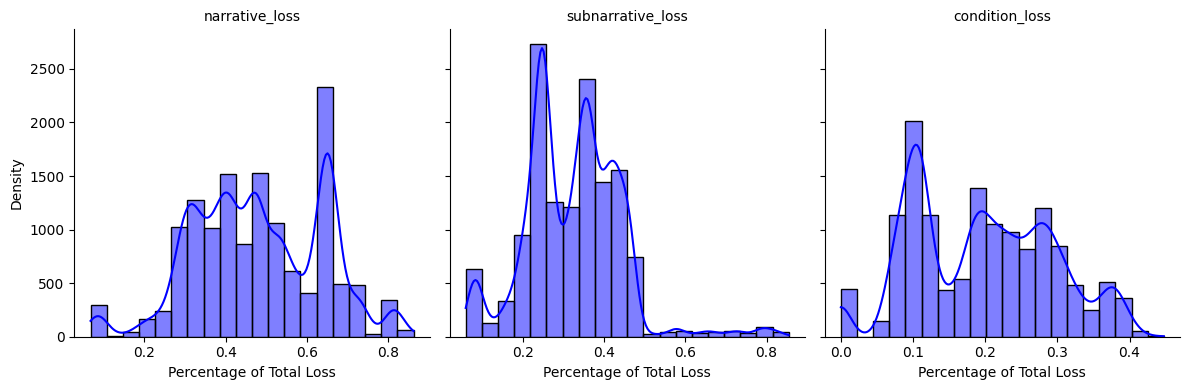

In [90]:
import seaborn as sns

df_melted = losses_df.melt(var_name='Column', value_name='Percentage')

g = sns.FacetGrid(df_melted, col='Column', height=4, sharey=True, sharex=False)

g.map(sns.histplot, 'Percentage', kde=True, bins=20, color='blue', alpha=0.5)

g.set_titles("{col_name}")
g.set_axis_labels("Percentage of Total Loss", "Density")

g.tight_layout()